In [1]:
# import osr_examples.scripts.environment_2d as environment_2d
import numpy as np
import pylab as pl
import sys
import heapq
from tqdm import tqdm
from sklearn.neighbors import KDTree
sys.path.append('osr_examples/scripts/')
import environment_2d
pl.ion()
np.random.seed(4)


# Probabilistic Road Maps

In [2]:
def generate_random_points(n, size_x = 10,size_y = 6):
    """
    Generate n random points on the board
    """
    temp = np.random.random((n,2))
    temp[:,0] *= size_x
    temp[:,1] *= size_y
    return temp

In [3]:
def march(env: environment_2d.Environment, current_point, target_point, step_length = 0.1):
    """
    Determines the existence of a straight path between 2 points.
    Returns true if this path exists
    """
    distance = ((target_point[0]- current_point[0])**2 +  (target_point[1]- current_point[1])**2)**(1/2)
    num_steps = int(distance//step_length)
    step = (
        ((target_point[0]- current_point[0])/distance)*step_length,
        ((target_point[1]- current_point[1])/distance)*step_length
    )
    current_loc = current_point
    for step_num in range(num_steps):
        
        current_loc = (current_loc[0]+step[0],current_loc[1]+step[1])
        if env.check_collision(*current_loc):
            return False
    return True, distance

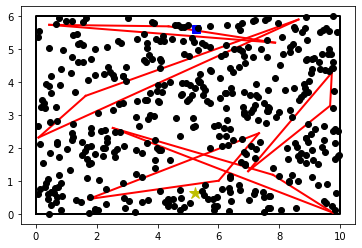

In [4]:
size_x = 10
size_y = 6
env = environment_2d.Environment(size_x, size_y, 5)
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)

    
    

# Sampling points
num_points_sampled = 500
x = 0
sample_points = generate_random_points(num_points_sampled)
sample_points = sample_points[np.array(list(map(lambda x: not env.check_collision(*x),sample_points))),:]
for point in sample_points:
    pl.plot(*point,'ko')
    
# sample_points+= [(x_start,y_start),(x_goal,y_goal)]

In [5]:
tree = KDTree(sample_points)

In [6]:
tile_window_size = 3

completed = set()
graph = {}


for point in tqdm(sample_points):
    candidate_points = sample_points[tree.query([point],k = 26)[1][0]]
    
    
    for candidate_point in candidate_points:
        
        if (tuple(point),tuple(candidate_point)) in completed or np.all(point == candidate_point):
            continue
        march_result = march(env,point,candidate_point,step_length = 0.005)
        if march_result:
            if tuple(point) in graph:
                graph[tuple(point)].append((tuple(candidate_point),march_result[1]))
            else:
                graph[tuple(point)]=[(tuple(candidate_point),march_result[1])]

            if tuple(candidate_point) in graph:
                graph[tuple(candidate_point)].append((tuple(point),march_result[1]))
            else:
                graph[tuple(candidate_point)]=[(tuple(point),march_result[1])]
        completed.add((tuple(candidate_point),tuple(point)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:18<00:00, 22.82it/s]


In [7]:
def connect_start_and_goal(env: environment_2d.Environment, tree, graph, start, goal):
    """
    Connect the start and goal node to the current graph(probabilistic road map)
    """
    for point in tqdm([start,goal]):
        candidate_points = sample_points[tree.query([point],k = 26)[1][0]]


        for candidate_point in candidate_points:

            if (tuple(point),tuple(candidate_point)) in completed or np.all(point == candidate_point):
                continue
            march_result = march(env,point,candidate_point,step_length = 0.005)
            if march_result:
                if tuple(point) in graph:
                    graph[tuple(point)].append((tuple(candidate_point),march_result[1]))
                else:
                    graph[tuple(point)]=[(tuple(candidate_point),march_result[1])]

                if tuple(candidate_point) in graph:
                    graph[tuple(candidate_point)].append((tuple(point),march_result[1]))
                else:
                    graph[tuple(candidate_point)]=[(tuple(point),march_result[1])]
            completed.add((tuple(candidate_point),tuple(point)))
    return graph

In [8]:
graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.20it/s]


In [9]:
def euclidean_distance(cur_node,goal_node):
    """
    Calculates the euclidean distance between two points.
    Used as a heuristic and to find the norm of vectors.
    """
    return ((goal_node[0]- cur_node[0])**2 +  (goal_node[1]- cur_node[1])**2)**(1/2)

In [10]:
def a_star(graph,start_node,goal_node):
    """
    Finds and returns a path, if it exists, between the start node and the goal node.
    """
    explored = {start_node}
    frontier = []

    for child_node,cost in graph[start_node]:

        heapq.heappush(
            frontier,
            (
                cost+euclidean_distance(child_node,goal_node),
                cost,
                child_node,
                [start_node,child_node]
            )
        )

    while frontier:
        _, g, current_node, path = heapq.heappop(frontier)

        if current_node in explored:
            continue
        if current_node == goal_node:
#             print(g,path)
            return path
        explored.add(current_node)

        for child_node, edge_cost in graph[current_node]:

            if child_node not in explored:
                heapq.heappush(
                    frontier,
                    (
                        g+edge_cost+euclidean_distance(child_node,goal_node),
                        g+edge_cost,
                        child_node,
                        path+[child_node]
                    )
                )
    
    

In [11]:
graph

{(5.244040800684734,
  3.825661464755962): [((5.058070707782574, 3.906309350206552),
   0.20270411165462207), ((5.349026016644526, 3.999350376601561),
   0.20295254043305902), ((5.147339709131451, 3.6213810621612383),
   0.22601235362665179), ((5.386054191468351, 4.001825726333953),
   0.22627781645397624), ((5.483675435180503, 3.842123901354369),
   0.2401994376943409), ((5.345126066065918, 4.06721071695732),
   0.2618478033442707), ((5.547408629425585, 3.7495850643845863),
   0.3127613438524725), ((5.488051182820824, 3.598784947135198),
   0.33318766609513856), ((4.9327489167427, 3.9856203549751923),
   0.349984976203763), ((5.026654861648216, 3.4803809668297028),
   0.4080138094954559), ((4.817671613999311, 3.959365385281309),
   0.446841606968999), ((5.390210781857193, 4.256867752981654),
   0.45530706825321243), ((4.980329091126755, 3.4354870045464434),
   0.47093521333383076), ((4.796878195669036, 3.6368652782291266),
   0.4853847910385124), ((4.777092210726374, 3.612493070772946

In [12]:
path = a_star(graph,(x_start,y_start),(x_goal,y_goal))

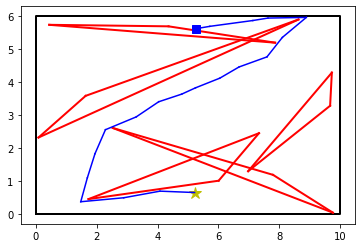

In [13]:
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")



# Path Shortcutting


In [14]:
def shorcut_path(path,max_reps = 1000):
    """
    Apply path shorcutting and return a shorter path
    """
    
    for _ in range(max_reps):

        num_edges = len(path)-1

        segment_1 = int(np.random.random()*num_edges)
        segment_2 = int(np.random.random()*num_edges)

        if segment_1 == segment_2:
            continue

        segment_1_start = path[segment_1]    
        segment_1_end = path[segment_1+1]
        segment_2_start = path[segment_2]    
        segment_2_end = path[segment_2+1]

        norm_1 = euclidean_distance(segment_1_start,segment_1_end)
        norm_2 = euclidean_distance(segment_2_start,segment_2_end)

        portion_1 = np.random.random()
        portion_2 = np.random.random()

        segment_1_step = ((segment_1_end[0]-segment_1_start[0]),(segment_1_end[1]-segment_1_start[1]))
        segment_2_step = ((segment_2_end[0]-segment_2_start[0]),(segment_2_end[1]-segment_2_start[1]))

        point_1 = (segment_1_start[0]+(segment_1_step[0]*portion_1),segment_1_start[1]+(segment_1_step[1]*portion_1))
        point_2 = (segment_2_start[0]+(segment_2_step[0]*portion_2),segment_2_start[1]+(segment_2_step[1]*portion_2))

        if march(env,point_1,point_2,step_length=0.005):
            if segment_1<segment_2:
                path = path[:segment_1+1]+[point_1,point_2]+path[segment_2+1:]
            elif segment_1>segment_2:
                segment_1,segment_2 = segment_2,segment_1
                path = path[:segment_1+1]+[point_2,point_1]+path[segment_2+1:]

    return path

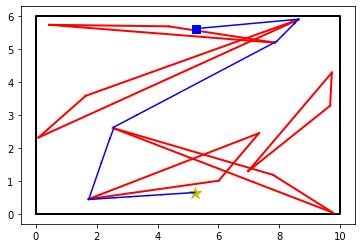

In [15]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

# Issues
- If the obstacle gets too small/ too thin, the algorithm will fail to
detect a collision and hence will allow the path to travel through an obstacle
- This could be overcome by using an algorithm to check the intersection of two lines
- There exists a trade off concerning the accuracy of a solution versus 
the time the solution takes to be computed. This is because, if we use smaller step sizes in the 
marching function, we can more accurately determine collisions, but the smaller the step size, 
the longer the algorithm takes to run

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.69it/s]


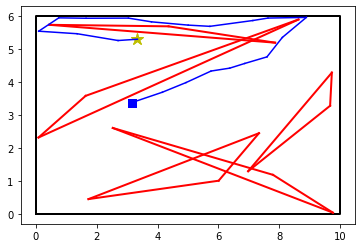

In [16]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


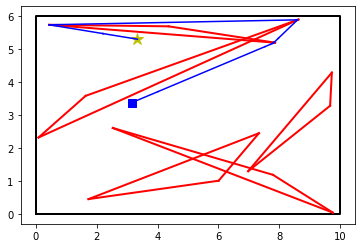

In [17]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.29it/s]


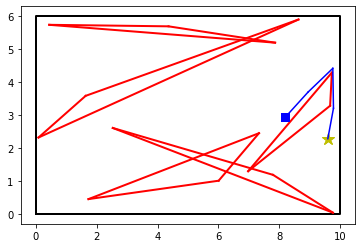

In [18]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


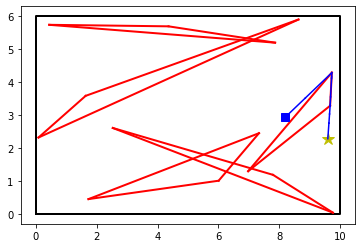

In [19]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.01it/s]


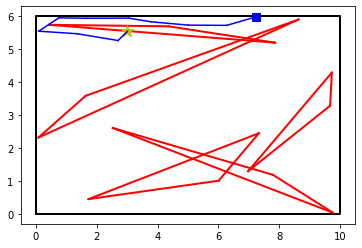

In [20]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


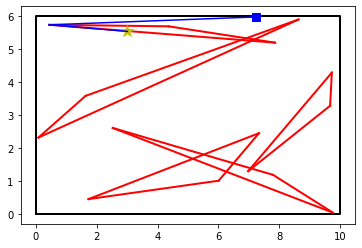

In [21]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.56it/s]


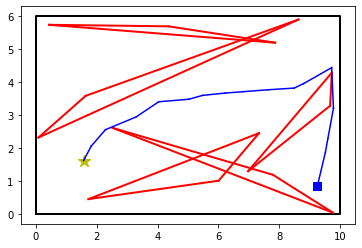

In [22]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


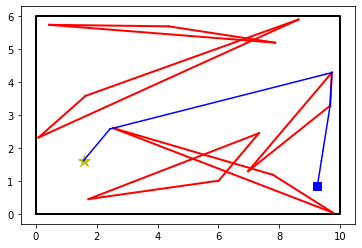

In [23]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]


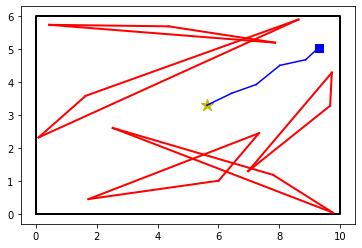

In [24]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,tree,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


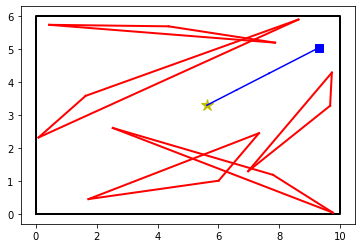

In [25]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")